### Please import the Boston housing dataset, do some EDA, and clean data. Then calculate linear regression. After that please use Polynomial Regression. Calculate RMSE and R squared for each. Please use sklearn to implement Linear Regression

### Dataset describtion
http://lib.stat.cmu.edu/datasets/boston

CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per 10,000 usd
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    percent lower status of the population
MEDV     Median value of owner-occupied homes in 1000's usd


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold

In [2]:
# Script Switches
scaling = False
k_fold = True
degree = 2

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')

In [4]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


There are no non-null values in the dataset.

### Distribution of medv:

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


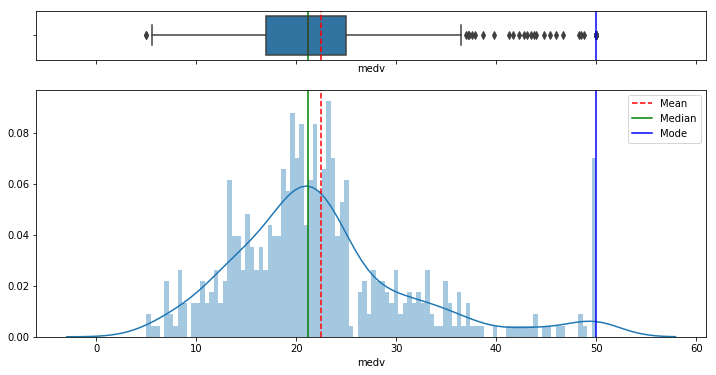

In [5]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)},figsize=(12, 6))
mean=df['medv'].mean()
median=df['medv'].median()
mode=df['medv'].mode().get_values()[0]

sns.boxplot(df['medv'], ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df['medv'], ax=ax_hist, bins=100)
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')
ax_hist.axvline(mode, color='b', linestyle='-')

plt.legend({'Mean':mean,'Median':median,'Mode':mode})

ax_box.set(xlabel='medv')
plt.show()

Distribution is not normal. Median and mean are pretty close, but mode is very far away. There is a very heavy tail in the higher price range. There seams to be an anomaly with houses of a price with 50k. Therefor I will cut those values from the dataset since there is no feaseable explanation.

In [6]:
df.groupby('medv')['crim'].count().sort_values()

medv
46.0     1
31.1     1
18.1     1
18.0     1
17.9     1
        ..
21.7     7
23.1     7
22.0     7
25.0     8
50.0    16
Name: crim, Length: 229, dtype: int64

In [7]:
# Cutting out anomal values
df_cut = df[df['medv'] < 50]
df = df_cut

## Data Cleaning:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 505
Data columns (total 14 columns):
crim       490 non-null float64
zn         490 non-null float64
indus      490 non-null float64
chas       490 non-null int64
nox        490 non-null float64
rm         490 non-null float64
age        490 non-null float64
dis        490 non-null float64
rad        490 non-null int64
tax        490 non-null int64
ptratio    490 non-null float64
b          490 non-null float64
lstat      490 non-null float64
medv       490 non-null float64
dtypes: float64(11), int64(3)
memory usage: 57.4 KB


All features have the correct data type and have Zero null entries. There are no obvious flaws in the data.

### Describtive Statistics:

In [9]:
#corrmat.sort_values(by='medv', axis=0, ascending=False)

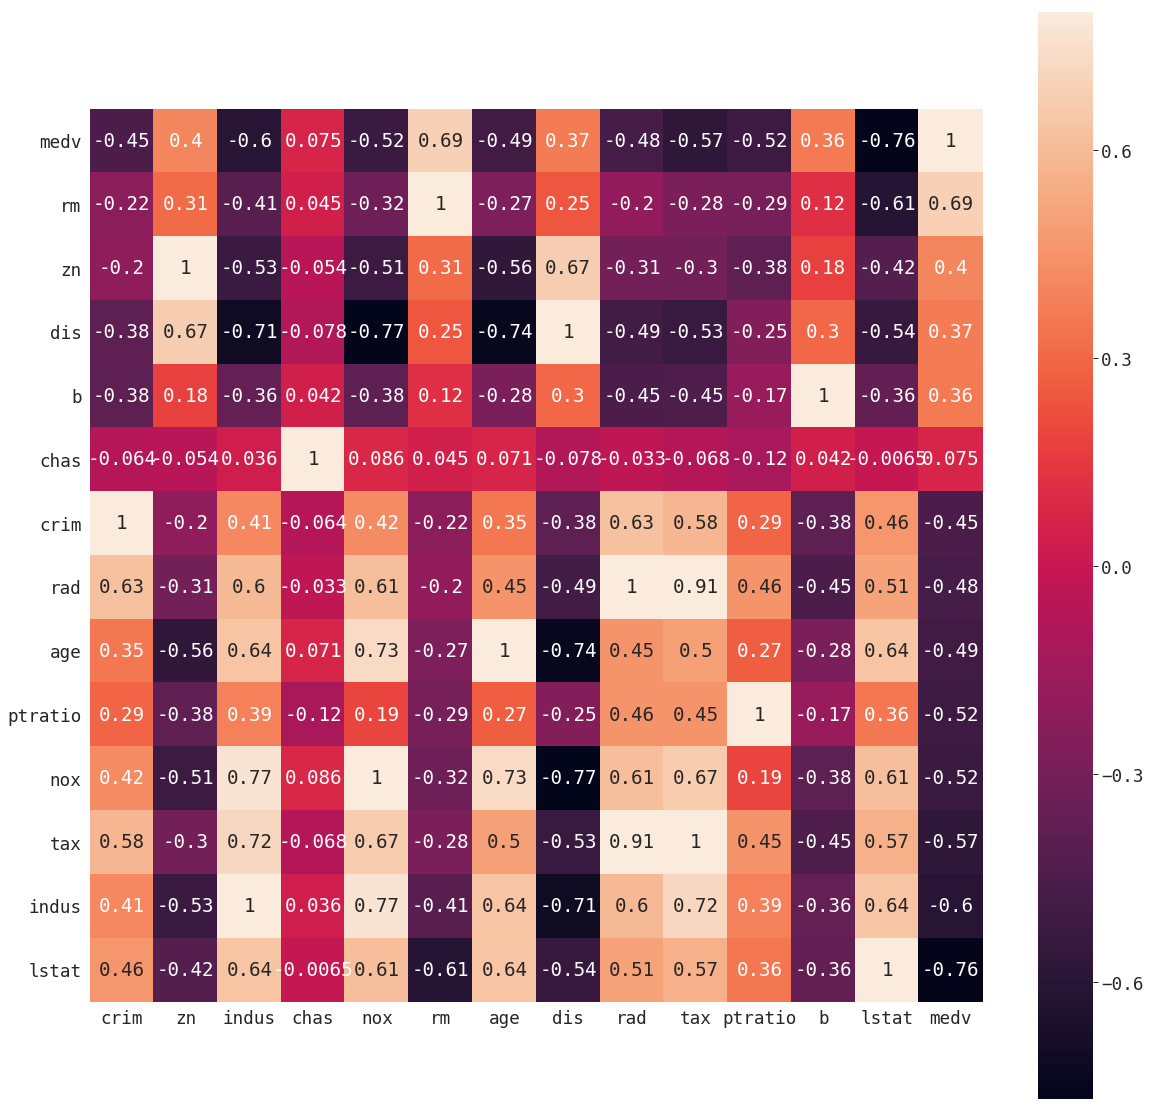

In [10]:
#mask = np.zeros_like(df.corr(), dtype=np.bool)
#mask[np.triu_indices_from(mask, k=1)] = True
sns.set(context="paper", font="monospace", font_scale=2)
corrmat = df.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
# # Drawing the heatmap using seaborn
ax = sns.heatmap(corrmat.sort_values(by='medv', axis=0, ascending=False), vmax=.8, square=True, annot=True);

In [11]:
corr_treshold = 0.42
df_corr = corrmat.sort_values(by='medv', axis=0, ascending=False)
# Create a list of the features above corr_treshold
high_corr_feat = list(df_corr['medv'][df_corr.iloc[:,0].abs() > corr_treshold].index)
high_corr_feat.remove('medv')

## Scaling and Splitting 

In [12]:
test_size = 0.2
df_mlr = df.loc[:, high_corr_feat]
mse_list = []
r2_list = []
rmse_list = []
i =0

# transform dataframe to numpy array
X = df_mlr.to_numpy()
y = df['medv'].to_numpy()

kf = KFold(n_splits=10)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    print(i)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

    if scaling:
        # Scaling x
        #scaler = MinMaxScaler()
        scaler = StandardScaler()
        scaled_x = scaler.fit_transform(df.iloc[:,:-1])
        columns = df.columns
        X = pd.DataFrame(scaled_x, columns=columns[:-1])

    ## Polynomial Regression with all high_corr_feat

    polynomial_features= PolynomialFeatures(degree=degree)
    X_poly_train = polynomial_features.fit_transform(X_train)
    X_poly_test = polynomial_features.fit_transform(X_test)

    # Create linear regression object
    regr_poly = linear_model.LinearRegression()

    # Train the model using the training sets
    regr_poly.fit(X_poly_train, y_train)

    # Make predictions using the testing set
    y_pred_poly_test = regr_poly.predict(X_poly_test)
    y_pred_poly_train = regr_poly.predict(X_poly_train)

    mse = mean_squared_error(y_test, y_pred_poly_test)
    r2 = r2_score(y_test, y_pred_poly_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly_test))

    mse_list.append(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)
    i += 1

print('THIS ARE THE RESULTS FOR POLYNOMIAL REGRESSION GRADE %s:')
# The mean squared error
print("Mean squared error: %.2f" % mean(mse_list))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % mean(r2_list))
# The root mean squared error
print("Root Mean squared error: %.2f" % mean(rmse_list))


0
1
2
3
4
5
6
7
8
9
THIS ARE THE RESULTS FOR POLYNOMIAL REGRESSION GRADE %s:


TypeError: 'numpy.float64' object is not callable

## Function to plot simple linear regression 

In [ ]:
def lin_regress_plot(df, col, test_size=20, plot=True):
    #split_point = int(df.shape[0] * split / 100)
    
    X = df[col].to_numpy()
    y = df['medv'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # Reshaping the arrays
    X_train = X_train[:, np.newaxis]
    y_train = y_train[:, np.newaxis]
    X_test = X_test[:, np.newaxis]
    y_test = y_test[:, np.newaxis]
    
    print(X_train.shape)
    # Use only one feature
    #X = data[:, np.newaxis]

    # Split the data into training/testing sets
    #X_train = X[:-split_point]
    #X_test = X[-split_point:]

    # Split the targets into training/testing sets
    #y_train = goal[:-split_point]
    #y_test = goal[-split_point:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred_test = regr.predict(X_test)
    y_pred_train = regr.predict(X_train)
    
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mse)
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % rmse)

    if plot:
        fig, (ax_test, ax_train) = plt.subplots(2, sharex=True, sharey=True, figsize=(9, 9))
    # Plot outputs for testset
        ax_test.scatter(X_test, y_test,  color='blue', label='y_test')
        ax_test.plot(X_test, y_pred_test, color='red', linewidth=3, label='y_linfit')
        ax_test.set_title('TEST SET')
        plt.xlabel(col)
        plt.ylabel('medv')
    # Plot outputs for trainset
        ax_train.scatter(X_train, y_train,  color='blue', label='y_train')
        plt.plot(X_train, y_pred_train, color='red', linewidth=3, label='y_linfit')
        ax_train.set_title('TRAIN SET')
        plt.xlabel(col)
        plt.ylabel('medv')
        plt.show()

## crim:
"Crimes rate by town. Since CRIM gauges the threat to well-being that households perceive in various neighborhoods of the Boston metropolitan area (assuming that crime rates are generally proportional to people's perception of danger) it should have a negative effect on housing values."[Hedonic Housing Prices and the Demand for Clean Air, Harrison, Rubinfeld] [Data Source FBI 1070]

In [ ]:
sns.distplot(df.crim, bins=80)
plt.xlim([0, 40])

In [ ]:
lin_regress_plot(df, 'crim')

### Conclusion about the crime rate:
As distribution and scatter plot indicate most datapoints have a crime value with zero. Otherwise the linear fit for the data is quite good.

In [ ]:
lin_regress_plot(df, 'zn')

In [ ]:
lin_regress_plot(df, 'lstat')

In [ ]:
lin_regress_plot(df, 'rm')

In [ ]:
lin_regress_plot(df, 'nox')

In [ ]:
lin_regress_plot(df, 'indus')